In [1]:
import pyspark
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Calculate the number of processors and the amount of memory on Beocat
# by parsing the slurm.conf file.

from collections import namedtuple

f = open(r"/homes/scotthutch/singularity_slurm/run_folders/etc/slurm.conf")
lines = f.readlines()
f.close()

NUM_PROCESSORS=0
NUM_MEM=0

lines = map(str.strip, lines)

nodes = []

for line in lines:
    if "NodeName" in line:
        headers = [thing.split("=")[0] for thing in line.split()]
        values = [thing.split("=")[1] for thing in line.split()]
        
        node_tuple = namedtuple("Node", headers)
        node = node_tuple(*values)
        nodes.append(node)

for node in nodes:
    NUM_PROCESSORS += int(node.CPUs)
    NUM_MEM += int(node.RealMemory)
    
print("Number of nodes: {}".format(len(nodes)))
print("Beocat NUM_PROCESSORS= {}".format(NUM_PROCESSORS))
print("Beocat NUM_MEM= {}".format(NUM_MEM))

Number of nodes: 362
Beocat NUM_PROCESSORS= 10980
Beocat NUM_MEM= 55821582


In [3]:
# Load the .csv file containing the output of the sacct command

from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import year
from pyspark.sql.functions import month
from pyspark.sql.functions import date_format
from pyspark.sql.functions import col
from pyspark.sql.functions import sum as pyspark_sum


job_schema = StructType([StructField("Account",StringType(),True),
                         StructField("AdminComment",StringType(),True),
                         StructField("AllocCPUS",IntegerType(),True),
                         StructField("AllocGRES",StringType(),True),
                         StructField("AllocNodes",IntegerType(),True),
                         StructField("AllocTRES",StringType(),True),
                         StructField("AssocID",IntegerType(),True),
                         StructField("AveCPU",StringType(),True),
                         StructField("AveCPUFreq",StringType(),True),
                         StructField("AveDiskRead",StringType(),True),
                         StructField("AveDiskWrite",StringType(),True),
                         StructField("AvePages",StringType(),True),
                         StructField("AveRSS",StringType(),True),
                         StructField("AveVMSize",StringType(),True),
                         StructField("BlockID",StringType(),True),
                         StructField("Cluster",StringType(),True),
                         StructField("Comment",StringType(),True),
                         StructField("ConsumedEnergy",StringType(),True),
                         StructField("ConsumedEnergyRaw",StringType(),True),
                         StructField("CPUTime",StringType(),True),
                         StructField("CPUTimeRAW",IntegerType(),True),
                         StructField("DerivedExitCode",StringType(),True),
                         StructField("Elapsed",StringType(),True),
                         StructField("ElapsedRaw",IntegerType(),True),
                         StructField("Eligible",TimestampType(),True),
                         StructField("End",TimestampType(),True),
                         StructField("ExitCode",StringType(),True),
                         StructField("GID",IntegerType(),True),
                         StructField("Group",StringType(),True),
                         StructField("JobID",StringType(),True),
                         StructField("JobIDRaw",StringType(),True),
                         StructField("JobName",StringType(),True),
                         StructField("Layout",StringType(),True),
                         StructField("MaxDiskRead",StringType(),True),
                         StructField("MaxDiskReadNode",StringType(),True),
                         StructField("MaxDiskReadTask",StringType(),True),
                         StructField("MaxDiskWrite",StringType(),True),
                         StructField("MaxDiskWriteNode",StringType(),True),
                         StructField("MaxDiskWriteTask",StringType(),True),
                         StructField("MaxPages",StringType(),True),
                         StructField("MaxPagesNode",StringType(),True),
                         StructField("MaxPagesTask",StringType(),True),
                         StructField("MaxRSS",StringType(),True),
                         StructField("MaxRSSNode",StringType(),True),
                         StructField("MaxRSSTask",StringType(),True),
                         StructField("MaxVMSize",StringType(),True),
                         StructField("MaxVMSizeNode",StringType(),True),
                         StructField("MaxVMSizeTask",StringType(),True),
                         StructField("McsLabel",StringType(),True),
                         StructField("MinCPU",StringType(),True),
                         StructField("MinCPUNode",StringType(),True),
                         StructField("MinCPUTask",StringType(),True),
                         StructField("NCPUS",IntegerType(),True),
                         StructField("NNodes",IntegerType(),True),
                         StructField("NodeList",StringType(),True),
                         StructField("NTasks",StringType(),True),
                         StructField("Priority",IntegerType(),True),
                         StructField("Partition",StringType(),True),
                         StructField("QOS",StringType(),True),
                         StructField("QOSRAW",IntegerType(),True),
                         StructField("ReqCPUFreq",StringType(),True),
                         StructField("ReqCPUFreqMin",StringType(),True),
                         StructField("ReqCPUFreqMax",StringType(),True),
                         StructField("ReqCPUFreqGov",StringType(),True),
                         StructField("ReqCPUS",IntegerType(),True),
                         StructField("ReqGRES",StringType(),True),
                         StructField("ReqMem",StringType(),True),
                         StructField("ReqNodes",IntegerType(),True),
                         StructField("ReqTRES",StringType(),True),
                         StructField("Reservation",StringType(),True),
                         StructField("ReservationId",StringType(),True),
                         StructField("Reserved",StringType(),True),
                         StructField("ResvCPU",StringType(),True),
                         StructField("ResvCPURAW",IntegerType(),True),
                         StructField("Start",TimestampType(),True),
                         StructField("State",StringType(),True),
                         StructField("Submit",TimestampType(),True),
                         StructField("Suspended",StringType(),True),
                         StructField("SystemCPU",StringType(),True),
                         StructField("SystemComment",StringType(),True),
                         StructField("Timelimit",StringType(),True),
                         StructField("TimelimitRaw",IntegerType(),True),
                         StructField("TotalCPU",StringType(),True),
                         StructField("TRESUsageInAve",StringType(),True),
                         StructField("TRESUsageInMax",StringType(),True),
                         StructField("TRESUsageInMaxNode",StringType(),True),
                         StructField("TRESUsageInMaxTask",StringType(),True),
                         StructField("TRESUsageInMin",StringType(),True),
                         StructField("TRESUsageInMinNode",StringType(),True),
                         StructField("TRESUsageInMinTask",StringType(),True),
                         StructField("TRESUsageInTot",StringType(),True),
                         StructField("TRESUsageOutAve",StringType(),True),
                         StructField("TRESUsageOutMax",StringType(),True),
                         StructField("TRESUsageOutMaxNode",StringType(),True),
                         StructField("TRESUsageOutMaxTask",StringType(),True),
                         StructField("TRESUsageOutMin",StringType(),True),
                         StructField("TRESUsageOutMinNode",StringType(),True),
                         StructField("TRESUsageOutMinTask",StringType(),True),
                         StructField("TRESUsageOutTot",StringType(),True),
                         StructField("UID",IntegerType(),True),
                         StructField("User",StringType(),True),
                         StructField("UserCPU",StringType(),True),
                         StructField("WCKey",StringType(),True),
                         StructField("WCKeyID",IntegerType(),True),
                         StructField("WorkDir",StringType(),True)])

all_jobs = spark.read.csv("/homes/scotthutch/beocat_slurm_raw.csv", sep="|", header=True, schema=job_schema)
print("Total number of jobs in the log is {}".format(all_jobs.count()))

base_jobs = all_jobs.filter(year(all_jobs.Submit)==2018).filter(~(all_jobs.JobID.contains("_")) & ~(all_jobs.JobID.contains(".")))
base_jobs_with_submit_date = base_jobs.withColumn("SubmitDate", date_format(base_jobs.Submit, "yyyy-MM-dd"))

print("Found {} jobs".format(base_jobs.count()))
base_jobs_with_submit_date.head()

Total number of jobs in the log is 10984901
Found 729008 jobs


Row(Account='beodefault', AdminComment=None, AllocCPUS=32, AllocGRES=None, AllocNodes=1, AllocTRES='cpu=32,mem=64G,node=1', AssocID=1076, AveCPU=None, AveCPUFreq=None, AveDiskRead=None, AveDiskWrite=None, AvePages=None, AveRSS=None, AveVMSize=None, BlockID=None, Cluster='beocat', Comment=None, ConsumedEnergy=None, ConsumedEnergyRaw=None, CPUTime='1-09:32:48', CPUTimeRAW=120768, DerivedExitCode='0:0', Elapsed='01:02:54', ElapsedRaw=3774, Eligible=datetime.datetime(2018, 2, 28, 11, 22, 12), End=datetime.datetime(2018, 2, 28, 12, 25, 10), ExitCode='0:0', GID=2655, Group='vtuoc_users', JobID='226781', JobIDRaw='226781', JobName='SnS-31N', Layout=None, MaxDiskRead=None, MaxDiskReadNode=None, MaxDiskReadTask=None, MaxDiskWrite=None, MaxDiskWriteNode=None, MaxDiskWriteTask=None, MaxPages=None, MaxPagesNode=None, MaxPagesTask=None, MaxRSS=None, MaxRSSNode=None, MaxRSSTask=None, MaxVMSize=None, MaxVMSizeNode=None, MaxVMSizeTask=None, McsLabel=None, MinCPU=None, MinCPUNode=None, MinCPUTask=None,

In [4]:
# Sort by start_times, end_times, and submit_times
start_times = base_jobs.select(["Submit", "Start", "End", "NCPUS", "ReqMem", "TimelimitRaw", "AllocTRES"]).sort(col("Start")).collect()
print("Done sorting by start times.")
end_times = base_jobs.select(["Submit", "Start", "End", "NCPUS", "ReqMem", "TimelimitRaw", "AllocTRES"]).sort(col("End")).collect()
print("Done sorting by end times.")
submit_times = base_jobs.select(["Submit", "Start", "End", "NCPUS", "ReqMem", "TimelimitRaw", "AllocTRES"]).sort(col("Submit")).collect()
print("Done sorting by submit times.")

Done sorting by start times.
Done sorting by end times.
Done sorting by submit times.


In [5]:
#queue depth calculations
# When a job is submitted, increase queue depth by one
# When a job is started, decrease queue depth by one

#print("Submit times are:")
#for i in range(10):
#    print(submit_times[i].Submit)

#print("Start times are:")
#for i in range(10):
#    print(start_times[i].Start)


submit_index = 0
start_index = 0

times = [submit_times[0].Submit]

current_queue_depth = 0
queue_depths = [current_queue_depth]

submit_exhausted = False

print("Doing {:,} calculations.".format(len(start_times)*2))

for i in range(len(start_times) * 2):
    if i%100000 == 0:
        print("i={:,}".format(i))
    
#    print("Submit[{}]: {}".format(submit_index, submit_times[submit_index].Submit))
#    print("Start[{}] : {}".format(start_index, start_times[start_index].Start))
    if not submit_exhausted and submit_times[submit_index].Submit <= start_times[start_index].Start:
#        print("Submit is earlier")
        current_queue_depth += 1
        queue_depths.append(current_queue_depth)
        times.append(submit_times[submit_index].Submit)
        submit_index += 1
        if submit_index == len(submit_times):
            submit_exhausted = True
    else:
#        print("Start is earlier")
        current_queue_depth -= 1
        
        times.append(start_times[start_index].Start)
        start_index += 1
        queue_depths.append(current_queue_depth)
#    print("Queue depth: {}\n".format(current_queue_depth))
print("Done with array operations.")

#for index, thing in enumerate(queue_depths):
#    print("{}: {}".format(times[index], thing))

queue_depth_schema = StructType([StructField("Submit",TimestampType(),True),
                                 StructField("QueueDepth",IntegerType(),True)])

queue_depth_df = spark.createDataFrame([(times[i], queue_depths[i]) for i in range(len(times))], schema=queue_depth_schema)
print("done")

Doing 1,458,016 calculations.
i=0
i=100,000
i=200,000
i=300,000
i=400,000
i=500,000
i=600,000
i=700,000
i=800,000
i=900,000
i=1,000,000
i=1,100,000
i=1,200,000
i=1,300,000
i=1,400,000
Done with array operations.
done


349
349


/opt/software/software/SciPy-bundle/2019.10-foss-2019b-Python-3.7.4/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


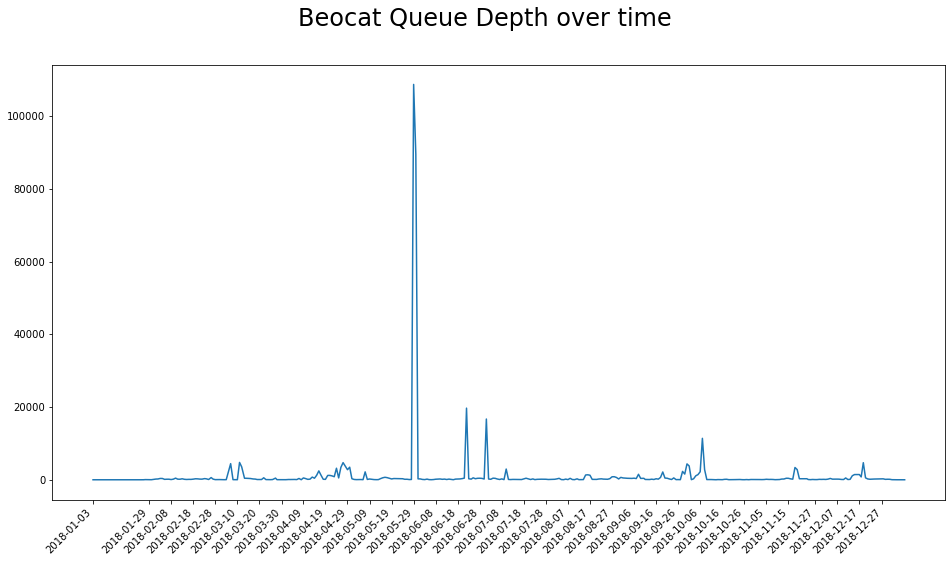

In [6]:
# Generate plot of queue depth over time
days = []
max_day_queue_depth = []

current_day = times[0]
max_for_day = -1

for index, date in enumerate(times):
    if date.date() == current_day.date():
        if max_for_day < queue_depths[index]:
            max_for_day = queue_depths[index]
            #print("Found a new max for {}: {}".format(current_day, max_for_day))
            continue
    else:
        days.append(current_day)
        max_day_queue_depth.append(max_for_day)
        max_for_day = queue_depths[index]
        current_day = date

print(len(days))
print(len(max_day_queue_depth))

fig = plt.figure(figsize=(16,8))
fig.suptitle("Beocat Queue Depth over time", size=24)
plt.plot(days, max_day_queue_depth)
plt.xticks(days[::10],rotation=45, ha="right")
plt.show()

In [7]:
# A helper functions to turn the log data's memory allocated into a number
# The format may differ slightly depending on your version of Slurm

import math

def get_mem_from_row(row):
    mem_requests = {}

    #Default setting for a job is 1Gb of mem.  Use this value unless they speicify differently
    mem = 1000
    
    alloc_tres_is_none = False
    try:
        if row.AllocTRES == "" or row.AllocTRES == None:
            alloc_tres_is_none = True
    except Exception as e:
        print(e)
        alloc_tres_is_none = True
    
    if not alloc_tres_is_none:
        alloc_tres_is_none = True
        if "Gc" in row.ReqMem:
            mem = int(row.ReqMem.strip("Gc")) * 1000 * row.NCPUS
        elif "Gn" in row.ReqMem:
            mem = int(row.ReqMem.strip("Gn")) * 1000 * row.NCPUS
        elif "Mn" in row.ReqMem:
            mem = int(row.ReqMem.strip("Mn")) * row.NCPUS
        elif "Mc" in row.ReqMem:
            mem = int(row.ReqMem.strip("Mc")) * row.NCPUS
        elif "0n" in row.ReqMem:
            # default for beocat is 1gb
            mem = 1000
        else:
            print("****Need to handle this: {}".format(row))
            
        if (row.ReqMem, row.NCPUS) not in mem_requests.keys():
            mem_requests[(row.ReqMem, row.NCPUS)] = mem
        elif mem_requests[(row.ReqMem, row.NCPUS)] != mem:
            print("Problem with: {} and {}".format(row.ReqMem, mem))
            
    if not alloc_tres_is_none:
        allocated_requirements = row.AllocTRES.split(",")
        for req in allocated_requirements:
            if "mem" in req:
                mem = req
                break
        label, value = mem.split("=")
        if "G" in value:
            try:
                mem = int(value.strip("G")) * 1000
            except ValueError as e:
                mem = int(math.ceil(float(value.strip("G")))) * 1000
        elif "M" in value:
            mem = int(value.strip("M"))
        elif "T" in value:
            mem = int(value.strip("T")) * 1000000
        else:
            print("****Handle this: {}".format(row))
            
        if (req, row.NCPUS) not in mem_requests.keys():
            mem_requests[(req, row.NCPUS)] = mem
        elif mem_requests[(req, row.NCPUS)] != mem:
            print("Problem with: {} and {}".format((req, row.NCPUS), mem))
    
    #for key, value in sorted(mem_requests.items(), key=lambda x: x[1]):
    #    print("{} = {}".format(key, value))
    
    return mem

In [8]:
# Calculate CPUs in use over time and memory in use over time
# Each time a job starts, the number of cpus in use increases by the number of cpus allocated to that job
# each time a job ends, the number of cpus in use decreases by the number of cpus allocated to that job

start_index = 0
end_index = 0

processors_in_use = 0
mem_in_use = 0

times = [start_times[0].Start]
utilizations = [0]
memory_usage = [0]

start_exhausted = False

print("Doing {:,} calculations.".format(len(start_times)*2))
for i in range(len(start_times) * 2):
    if i%100000 == 0:
        print("i={:,}".format(i))
        
    if not start_exhausted and start_times[start_index].Start <= end_times[end_index].End:
        processors_in_use += start_times[start_index].NCPUS
        mem_in_use += get_mem_from_row(start_times[start_index])
        if mem_in_use > NUM_MEM:
            mem_in_use = NUM_MEM
        times.append(start_times[start_index].Start)
        start_index += 1
        if start_index == len(start_times):
            start_exhausted = True
    else:
        processors_in_use -= end_times[end_index].NCPUS
        mem_in_use -= get_mem_from_row(end_times[end_index])
        if mem_in_use < 0:
            mem_in_use = 0
        times.append(end_times[end_index].End)
        end_index += 1
    utilizations.append(processors_in_use)
    memory_usage.append(mem_in_use)

print("Done with array operations.")

Doing 1,458,016 calculations.
i=0
i=100,000
i=200,000
i=300,000
i=400,000
i=500,000
i=600,000
i=700,000
i=800,000
i=900,000
i=1,000,000
i=1,100,000
i=1,200,000
i=1,300,000
i=1,400,000
Done with array operations.


355
355


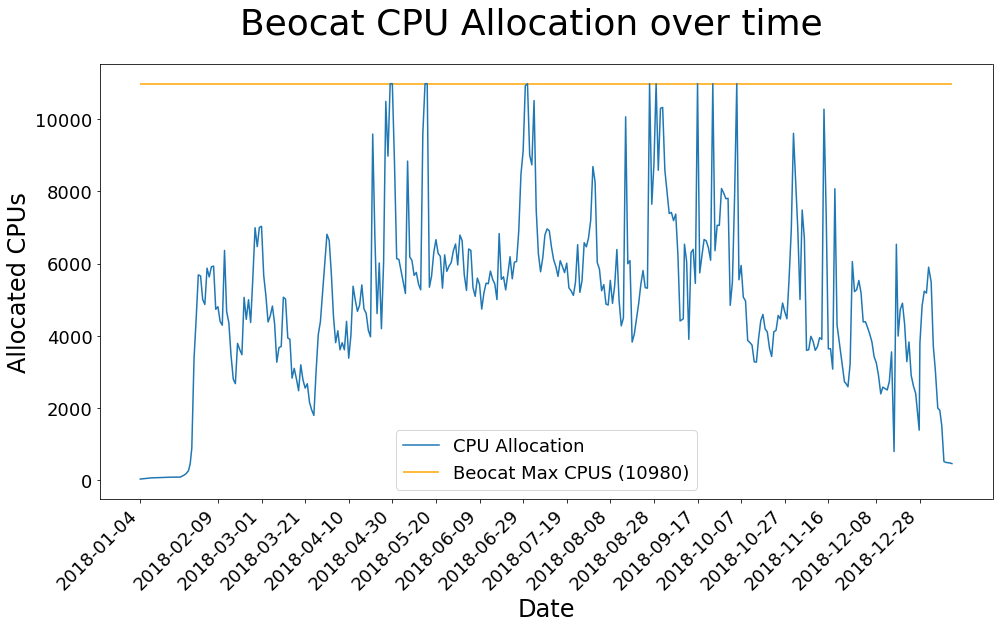

In [9]:
# CPU utilization graph generation

days = []
max_day_utils = []

current_day = times[0]
max_for_day = -1
for index, date in enumerate(times):
    if date.date() == current_day.date():
        if max_for_day < utilizations[index]:
            max_for_day = utilizations[index]
            #print("Found a new max for {}: {}".format(current_day, max_for_day))
            if max_for_day > NUM_PROCESSORS:
                # There's some logic error with suspended jobs I suspect?
                #print("Bad things")
                max_for_day = NUM_PROCESSORS
            continue
    else:
        days.append(current_day)
        max_day_utils.append(max_for_day)
        max_for_day = utilizations[index]
        current_day = date

print(len(days))
print(len(max_day_utils))

fig = plt.figure(figsize=(16,8))
fig.suptitle("Beocat CPU Allocation over time", size=36)
plt.plot(days, max_day_utils, label="CPU Allocation")
plt.xticks(days[::20],rotation=45, ha="right", size=18)
plt.yticks(size=18)
plt.hlines(NUM_PROCESSORS, days[0], days[-1], color="orange", label="Beocat Max CPUS ({})".format(NUM_PROCESSORS))
plt.ylabel("Allocated CPUs", size=24)
plt.xlabel("Date", size=24)
plt.legend(fontsize=18)
plt.savefig("2018_beo_util.png")
plt.show()

355
355


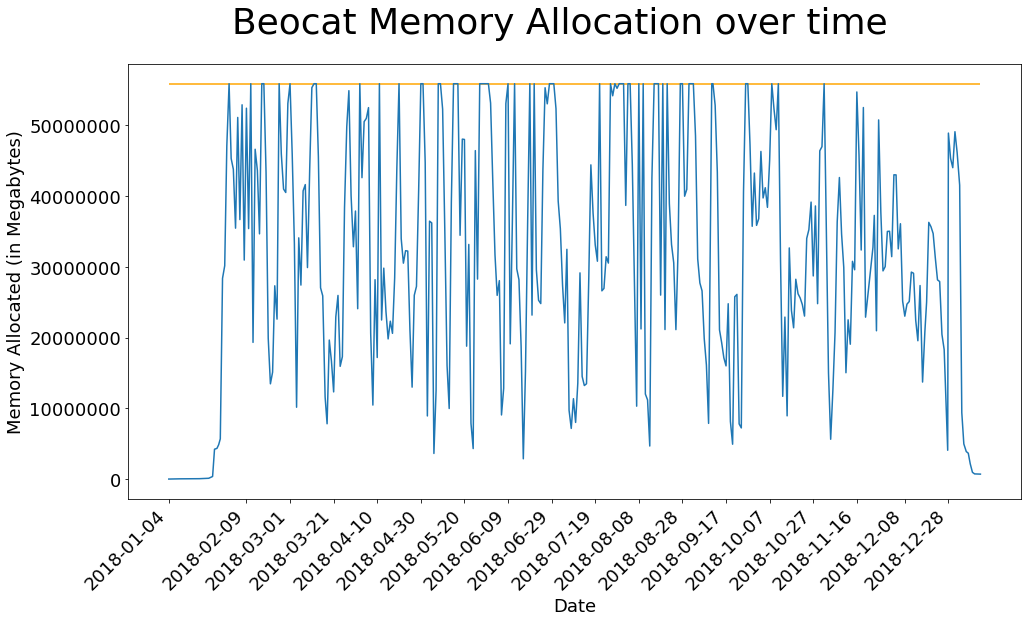

In [10]:
# Memory utilization graph generation
days = []
max_mem_utils = []

current_day = times[0]
max_for_day = -1
for index, date in enumerate(times):
    if date.date() == current_day.date():
        if max_for_day < memory_usage[index]:
            max_for_day = memory_usage[index]
            #print("Found a new max for {}: {}".format(current_day, max_for_day))
            #if max_for_day > NUM_MEM:
                #print("Bad things")
            #    max_for_day = NUM_MEM
            continue
    else:
        days.append(current_day)
        max_mem_utils.append(max_for_day)
        max_for_day = memory_usage[index]
        current_day = date

print(len(days))
print(len(max_mem_utils))

fig = plt.figure(figsize=(16,8))
fig.suptitle("Beocat Memory Allocation over time", size=36)
plt.plot(days, max_mem_utils)
plt.xticks(days[::20],rotation=45, ha="right", size=18)
plt.yticks(size=18)
plt.hlines(NUM_MEM, days[0], days[-1], color="orange")
plt.ylabel("Memory Allocated (in Megabytes)", size=18)
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
plt.xlabel("Date", size=18)
fig.savefig("beo_mem_allocation.png")
plt.show()